In [1]:
!pip install neptune-client
!pip install -q efficientnet_pytorch


import os
import cv2
import json
import torch
import random
import numpy as np
import pandas as pd
from torch import nn
from tqdm import tqdm
import efficientnet_pytorch
import neptune.new as neptune
from matplotlib import pyplot as plt
from albumentations.pytorch import ToTensorV2
from torch.utils.data import Dataset, DataLoader
from albumentations import VerticalFlip, Normalize, Compose, Resize, \
                           RandomResizedCrop, Transpose, HorizontalFlip, \
                           Rotate, RandomBrightnessContrast, ShiftScaleRotate

     |████████████████████████████████| 316 kB 600 kB/s            
  Preparing metadata (setup.py) ... - done
     |████████████████████████████████| 67 kB 3.8 MB/s             
  Created wheel for neptune-client: filename=neptune_client-0.16.0-py2.py3-none-any.whl size=565728 sha256=6809522dfda0aefd1d435a3d83190f701a2b7b846d34aa67b15c28ad167c9a1d
  Stored in directory: /root/.cache/pip/wheels/d3/96/77/26728c98b5324009116ccf98ab63768eecbd3f03bd60404e90
Successfully built neptune-client


In [2]:
CFG = dict(dr=.2,
           seed=11,
           lr=5e-5,
           n_epochs=20,
           auto_break_n=3,
           img_size=[256] * 2,
           path_save_model='model.torch'
          )

# Neptun

In [3]:
hidden_data = "######"

run = neptune.init(
    project=hidden_data,
    api_token=hidden_data,
)

run["parameters"] = CFG

https://app.neptune.ai/petr.square/EuroSat-Dataset/e/EUR-4
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#.stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.


# Path

In [4]:
base_dir = '../input/eurosat-dataset/EuroSAT'

test_path = f'{base_dir}/test.csv'
train_path = f'{base_dir}/train.csv'
validation_path = f'{base_dir}/validation.csv'

decoder_path = f"{base_dir}/label_map.json"

# Load

In [5]:
train = pd.read_csv(train_path, index_col=[0])
validation = pd.read_csv(validation_path, index_col=[0])
test = pd.read_csv(test_path, index_col=[0])

In [6]:
with open(decoder_path) as jsonFile:
    decoder = json.load(jsonFile)

reverse_decoder = {v: k for k, v in decoder.items()}
reverse_decoder

{0: 'AnnualCrop',
 1: 'Forest',
 2: 'HerbaceousVegetation',
 3: 'Highway',
 4: 'Industrial',
 5: 'Pasture',
 6: 'PermanentCrop',
 7: 'Residential',
 8: 'River',
 9: 'SeaLake'}

# Seed

In [7]:
def seed_everything(seed: int) -> None:
    """Seed all
    Parameters
    ----------
    seed : int
        The seed value
    """
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    if torch.cuda.is_available():
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

seed_everything(CFG['seed'])

# Data generator

In [8]:
class Data_generator(Dataset):
    def __init__(self, path:str, data:pd.DataFrame, transforms):
        self.path = path
        self.transforms = transforms
        
        self.target = data.Label
        self.image_names = data.Filename
    
        
    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, index):
        x = cv2.imread(os.path.join(self.path, self.image_names[index]))
        x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)

        if self.transforms:
            x = self.transforms(image=x)['image']
        
        y = torch.tensor(self.target[index], dtype=torch.long)
            
        return {'X': x, 'y': y}

# Transformation

In [9]:
transforms_train = Compose([
            RandomResizedCrop(*CFG['img_size']),
            Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
            HorizontalFlip(p=0.5),
            VerticalFlip(p=0.5),
            Rotate(limit=180, p=0.7),
            ShiftScaleRotate(
                shift_limit = 0.1, scale_limit=0.1, rotate_limit=45, p=0.5
            ),
            RandomBrightnessContrast(
                brightness_limit=(-0.1, 0.1),
                contrast_limit=(-0.1, 0.1), p=0.5
            ),
            ToTensorV2()
        ],
        p=1
    )

transforms_valid =  Compose([
    
    Resize(*CFG['img_size']),
    Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
    ),
    ToTensorV2()
    ],
    p=1
)

# DataLoad

In [10]:
train_set = Data_generator(base_dir, train, transforms_train)
valid_set = Data_generator(base_dir, validation, transforms_valid)
test_set = Data_generator(base_dir, test, transforms_valid)

In [11]:
train_loader = DataLoader(train_set, batch_size=64, shuffle=True, num_workers=4)
valid_loader = DataLoader(valid_set, batch_size=64, shuffle=False, num_workers=4)
test_loader = DataLoader(test_set, batch_size=64, shuffle=False, num_workers=4)

/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


# Model

In [12]:
model = efficientnet_pytorch.EfficientNet.from_pretrained("efficientnet-b0")
model._fc = nn.Linear(in_features=1280, out_features=10, bias=True)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=CFG['lr'])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth


  0%|          | 0.00/20.4M [00:00<?, ?B/s]

Loaded pretrained weights for efficientnet-b0


# Change device

In [13]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

# Class Trainer

In [14]:
class Trainer:
    
    def __init__(self, model, criterion, optimizer, scheduler, epochs, device, path_save_model='model.torch', auto_break_n=1000, run=None):
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.epochs = epochs
        self.history_loss = []
        self.history_acc = []
        self.history_loss_val = []
        self.history_acc_val = []
        self.best_valid_score = 0
        self.device = device
        self.path_save_model = path_save_model
        self.auto_break_n = auto_break_n
        self.run = run
        
        self.no_improvement_epoch = 0

        self.model.to(self.device)

    

    def fit(self, train_loader, valid_loader):
        
        for epoch in range(self.epochs):
            self.model.train()
            loss_score, correct = 0, 0
            total = 0
            
            for batch in tqdm(train_loader):

                x_batch, y_batch = batch["X"].to(self.device), batch["y"].to(self.device)
                
                # .forward()
                logits = self.model(x_batch)
                loss = self.criterion(logits, y_batch)
                                
                loss_score += loss.item()
                _, predicted = logits.max(1)
                total += y_batch.shape[0] 
                correct += predicted.eq(y_batch).sum().item()

                self.optimizer.zero_grad()
                loss.backward()
                # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
                # it's also improve f1 accuracy slightly
                nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)
                self.optimizer.step()
            
            loss_score = loss_score / len(train_loader)
            acc_score = correct/total
            self.history_loss.append(loss_score)
            self.history_acc.append(acc_score)
            
            print('=' * 100)
            print(f"\033[1;34m=> {epoch + 1} <= epoch")
            print(f'\033[1;31m Train Loss: {loss_score} | Accuracy: {acc_score}%')
            print('- ' * 50)

            if self.run:
                self.run['train/epoch/loss'].log(loss_score)
                self.run['train/epoch/accuracy'].log(acc_score)

            if valid_loader:
                loss_score_val, acc_score_val = self.test_score(valid_loader, "\033[1;36m Validation")
                
                self.history_loss_val.append(loss_score_val)
                self.history_acc_val.append(acc_score_val)
                
                if self.scheduler:
                    self.scheduler.step(loss_score_val)
                
                if self.run:
                    self.run['valid/epoch/loss'].log(loss_score_val)
                    self.run['valid/epoch/accuracy'].log(acc_score_val)
                
                if acc_score_val > self.best_valid_score:
                    self.no_improvement_epoch = 0
                    self.best_valid_score = acc_score_val
                    self.save_model(epoch + 1, self.path_save_model)
                else:  
                    self.no_improvement_epoch += 1
                
                    
                print(f"no improvement_iter = {self.no_improvement_epoch}")
                if self.no_improvement_epoch == self.auto_break_n:
                    print('Auto_break !!!')
                    self.run.stop()
                    break
            
            
    def test_score(self, valid_loader, info=""):
        self.model.eval() # switch for some specific layers/parts
        loss_score, correct = 0, 0
        total = 0

        for batch in tqdm(valid_loader):
            
            x_batch, y_batch = batch["X"].to(self.device), batch["y"].to(self.device)
            
            with torch.no_grad():
                
                logits = self.model(x_batch)
                loss = criterion(logits, y_batch)

                loss_score += loss.item()
                _, predicted = logits.max(1)
                total += y_batch.shape[0] 
                correct += predicted.eq(y_batch).sum().item()
                
        loss_score = loss_score / len(valid_loader)
        acc_score = correct/total
        print(f'{info} Loss : {loss_score} | Accuracy: {acc_score}%')
        
        return loss_score, acc_score
    
    def save_model(self, n_epoch, save_path):
        torch.save(
            {
                "model_state_dict": self.model.state_dict(),
                "optimizer_state_dict": self.optimizer.state_dict(),
                "best_valid_score": self.best_valid_score,
                "n_epoch": n_epoch,
            },
            save_path,
        )
        if self.run:
            self.run[f'model/saved_model'].upload(save_path)

In [15]:
mod = Trainer(model, criterion, optimizer, scheduler, CFG['n_epochs'], device, CFG['path_save_model'], CFG['auto_break_n'], run)
mod.fit(train_loader, valid_loader)

100%|██████████| 296/296 [02:16<00:00,  2.17it/s]


=> 1 <= epoch
 Train Loss: 1.4031570191318925 | Accuracy: 0.561005291005291%
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 


100%|██████████| 85/85 [00:19<00:00,  4.40it/s]


 Validation Loss : 0.639911503476255 | Accuracy: 0.7994444444444444%
no improvement_iter = 0


100%|██████████| 296/296 [02:06<00:00,  2.33it/s]


=> 2 <= epoch
 Train Loss: 0.7888911499364956 | Accuracy: 0.7262962962962963%
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 


100%|██████████| 85/85 [00:14<00:00,  5.76it/s]


 Validation Loss : 0.2541017959442209 | Accuracy: 0.917037037037037%
no improvement_iter = 0


100%|██████████| 296/296 [02:07<00:00,  2.31it/s]


=> 3 <= epoch
 Train Loss: 0.6644049417730924 | Accuracy: 0.7631746031746032%
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 


100%|██████████| 85/85 [00:14<00:00,  5.90it/s]


 Validation Loss : 0.18109126275076587 | Accuracy: 0.9405555555555556%
no improvement_iter = 0


100%|██████████| 296/296 [02:08<00:00,  2.30it/s]


=> 4 <= epoch
 Train Loss: 0.599652552624812 | Accuracy: 0.7834920634920635%
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 


100%|██████████| 85/85 [00:14<00:00,  5.85it/s]


 Validation Loss : 0.15124907614115407 | Accuracy: 0.950925925925926%
no improvement_iter = 0


100%|██████████| 296/296 [02:08<00:00,  2.31it/s]


=> 5 <= epoch
 Train Loss: 0.5742492055570757 | Accuracy: 0.7914814814814815%
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 


100%|██████████| 85/85 [00:15<00:00,  5.47it/s]


 Validation Loss : 0.13817307925509179 | Accuracy: 0.952962962962963%
no improvement_iter = 0


100%|██████████| 296/296 [02:08<00:00,  2.30it/s]


=> 6 <= epoch
 Train Loss: 0.5411651283502579 | Accuracy: 0.8017989417989418%
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 


100%|██████████| 85/85 [00:14<00:00,  5.91it/s]


 Validation Loss : 0.12703185881871512 | Accuracy: 0.9598148148148148%
no improvement_iter = 0


100%|██████████| 296/296 [02:08<00:00,  2.30it/s]


=> 7 <= epoch
 Train Loss: 0.5294947533591373 | Accuracy: 0.8064021164021165%
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 


100%|██████████| 85/85 [00:13<00:00,  6.09it/s]


 Validation Loss : 0.11727768846458811 | Accuracy: 0.96%
no improvement_iter = 0


100%|██████████| 296/296 [02:08<00:00,  2.30it/s]


=> 8 <= epoch
 Train Loss: 0.519731571746839 | Accuracy: 0.811058201058201%
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 


100%|██████████| 85/85 [00:15<00:00,  5.51it/s]


 Validation Loss : 0.11758881841430112 | Accuracy: 0.9633333333333334%
no improvement_iter = 0


100%|██████████| 296/296 [02:08<00:00,  2.30it/s]


=> 9 <= epoch
 Train Loss: 0.5018140493413886 | Accuracy: 0.816984126984127%
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 


100%|██████████| 85/85 [00:13<00:00,  6.17it/s]


 Validation Loss : 0.12026831267524839 | Accuracy: 0.9631481481481482%
no improvement_iter = 1


100%|██████████| 296/296 [02:09<00:00,  2.29it/s]


=> 10 <= epoch
 Train Loss: 0.5012175601881903 | Accuracy: 0.8170899470899471%
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 


100%|██████████| 85/85 [00:13<00:00,  6.17it/s]


 Validation Loss : 0.09450176007470444 | Accuracy: 0.9692592592592593%
no improvement_iter = 0


100%|██████████| 296/296 [02:09<00:00,  2.29it/s]


=> 11 <= epoch
 Train Loss: 0.48126594853159543 | Accuracy: 0.8246031746031746%
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 


100%|██████████| 85/85 [00:14<00:00,  5.86it/s]


 Validation Loss : 0.10007785601157915 | Accuracy: 0.9664814814814815%
no improvement_iter = 1


100%|██████████| 296/296 [02:08<00:00,  2.30it/s]


=> 12 <= epoch
 Train Loss: 0.47275146892344627 | Accuracy: 0.8265608465608466%
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 


100%|██████████| 85/85 [00:14<00:00,  5.71it/s]


 Validation Loss : 0.09401423951734186 | Accuracy: 0.9681481481481482%
no improvement_iter = 2


100%|██████████| 296/296 [02:07<00:00,  2.32it/s]


=> 13 <= epoch
 Train Loss: 0.4739962422565834 | Accuracy: 0.8272486772486772%
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 


100%|██████████| 85/85 [00:13<00:00,  6.16it/s]


 Validation Loss : 0.08865645453196895 | Accuracy: 0.9701851851851852%
no improvement_iter = 0


100%|██████████| 296/296 [02:08<00:00,  2.31it/s]


=> 14 <= epoch
 Train Loss: 0.4644973648561014 | Accuracy: 0.8308465608465608%
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 


100%|██████████| 85/85 [00:14<00:00,  6.00it/s]


 Validation Loss : 0.09379140204845873 | Accuracy: 0.9679629629629629%
no improvement_iter = 1


100%|██████████| 296/296 [02:08<00:00,  2.30it/s]


=> 15 <= epoch
 Train Loss: 0.4604587812681456 | Accuracy: 0.8298941798941799%
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 


100%|██████████| 85/85 [00:14<00:00,  5.83it/s]


 Validation Loss : 0.08564764337395044 | Accuracy: 0.97%
no improvement_iter = 2


100%|██████████| 296/296 [02:09<00:00,  2.29it/s]


=> 16 <= epoch
 Train Loss: 0.4587453602234254 | Accuracy: 0.831005291005291%
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 


100%|██████████| 85/85 [00:13<00:00,  6.21it/s]


 Validation Loss : 0.08671015368445831 | Accuracy: 0.9712962962962963%
no improvement_iter = 0


100%|██████████| 296/296 [02:09<00:00,  2.29it/s]


=> 17 <= epoch
 Train Loss: 0.4460846328654805 | Accuracy: 0.8344444444444444%
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 


100%|██████████| 85/85 [00:14<00:00,  5.83it/s]


 Validation Loss : 0.07461165352621774 | Accuracy: 0.975%
no improvement_iter = 0


100%|██████████| 296/296 [02:08<00:00,  2.30it/s]


=> 18 <= epoch
 Train Loss: 0.45348752969624223 | Accuracy: 0.8347089947089947%
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 


100%|██████████| 85/85 [00:15<00:00,  5.55it/s]


 Validation Loss : 0.06939189713448286 | Accuracy: 0.977037037037037%
no improvement_iter = 0


100%|██████████| 296/296 [02:08<00:00,  2.30it/s]


=> 19 <= epoch
 Train Loss: 0.44597391819430365 | Accuracy: 0.8383597883597883%
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 


100%|██████████| 85/85 [00:13<00:00,  6.22it/s]


 Validation Loss : 0.07191252207849175 | Accuracy: 0.9751851851851852%
no improvement_iter = 1


100%|██████████| 296/296 [02:08<00:00,  2.30it/s]


=> 20 <= epoch
 Train Loss: 0.44268158168808835 | Accuracy: 0.835026455026455%
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 


100%|██████████| 85/85 [00:13<00:00,  6.18it/s]


 Validation Loss : 0.06305031679324148 | Accuracy: 0.9787037037037037%
no improvement_iter = 0


# Test score

In [16]:
mod.test_score(test_loader, "\033[0;1m Test")

100%|██████████| 43/43 [00:09<00:00,  4.53it/s]

 Test Loss : 0.058114730078878615 | Accuracy: 0.9829629629629629%


(0.058114730078878615, 0.9829629629629629)

# Plot accuracy & loss

In [17]:
def plot_history(history, history_val, ylabel="", legend=['Train','Valid'], title='Train vs Valid'):
    plt.plot(history,'-o')
    plt.plot(history_val,'-o')
    
    plt.xlabel('epoch')
    plt.ylabel(ylabel)
    
    if ylabel == 'accuracy':
        plt.ylim(0, 1)
        
    plt.xticks(range(len(history)));
    
    plt.legend(legend)
    plt.title('Train vs Valid')

    plt.show()

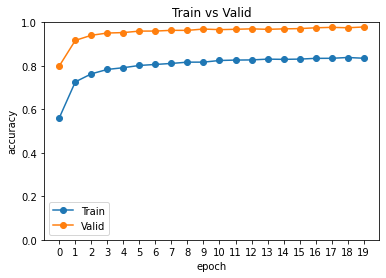

In [18]:
plot_history(np.array(mod.history_acc),
             np.array(mod.history_acc_val),
            'accuracy')

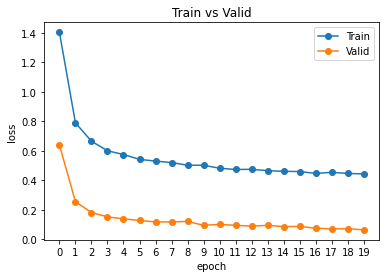

In [19]:
plot_history(np.array(mod.history_loss),
             np.array(mod.history_loss_val),
            'loss')